# Импорт библиотек

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from scipy.stats import norm, multivariate_normal, gaussian_kde, dirichlet, wishart, t
from scipy.integrate import quad, nquad
from scipy.special import gammaln, psi, digamma, gamma
from scipy.linalg import det, inv
from sklearn.model_selection import train_test_split
import pints, pints.plot

# Генерируем сам датасет

In [29]:
# Параметры
n_points = 500         # Количество точек
dim = 2                # Размерность (для двумерных данных)

# Матрица переходов A (произвольная, стабильная)
A = np.array([
    [0.6, 0.2],
    [0.1, 0.7]
])

# Ковариационная матрица шума
Sigma = np.array([
    [1.0, 0.3],
    [0.3, 1.0]
])

# Инициализация начального вектора y_0
np.random.seed(42)  # Для воспроизводимости
y_prev = np.random.multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim))

# Генерация временного ряда
data = []
for t in range(n_points):
    error = np.random.multivariate_normal(mean=np.zeros(dim), cov=Sigma)
    y_t = A @ y_prev + error
    data.append(y_t)
    y_prev = y_t

# Преобразуем в массив и DataFrame
data_array = np.array(data)
df = pd.DataFrame(data_array, columns=['x1', 'x2'])

# Сохраняем в CSV (если нужно)
df.to_csv('synthetic_var_dataset.csv', index=False)

print("Первые 5 строк датасета:")
print(df.head())

Первые 5 строк датасета:
         x1        x2
0 -1.152844  0.331740
1 -0.298061  0.167197
2 -1.872620 -0.731950
3 -1.212442 -0.000142
4 -0.078345 -0.023254


In [30]:
np_X = data_array[:, 0].reshape(-1, 1)
np_Y = data_array[:, 1].reshape(-1, 1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    np_X, 
    np_Y, 
    test_size=0.2,  # Доля тестовой выборки (можно указать train_size)
    random_state=42,  # Для воспроизводимости
)

XY_train = np.concatenate([X_train, y_train], axis = 1)
XY_test = np.concatenate([X_test, y_test], axis = 1)

n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]

In [32]:
# minimum = int(min(np_X)[0] * 1000 - 1)
# maximum = int(max(np_X)[0] * 1000 + 1)
# a_s = np.array([i / 1000 for i in range(minimum, maximum)])

## Визуализация

### Временные ряды

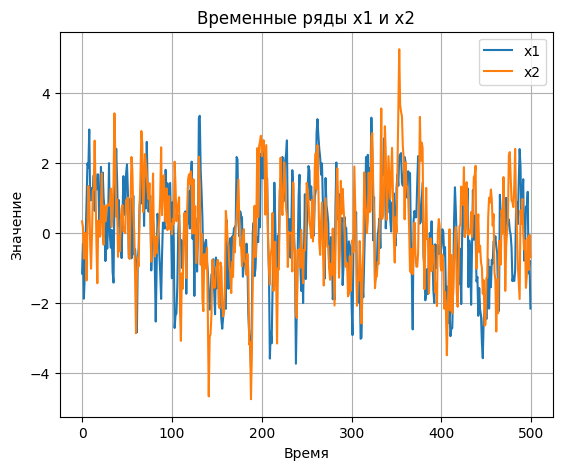

In [33]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(df['x1'], label='x1')
plt.plot(df['x2'], label='x2')
plt.title('Временные ряды x1 и x2')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

### Фазовый портрет (x1 vs x2)

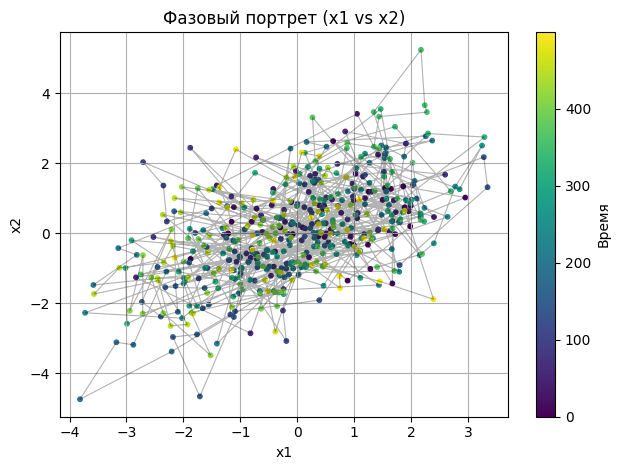

In [34]:
plt.scatter(df['x1'], df['x2'], c=range(n_points), cmap='viridis', s=10)
plt.plot(df['x1'], df['x2'], 'k-', alpha=0.3, linewidth=0.8)
plt.colorbar(label='Время')
plt.title('Фазовый портрет (x1 vs x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)

plt.tight_layout()
plt.show()

# GMR

## GMM

Подбор лучшей модели

In [36]:
def p_a(a, gmm, cov_type):
    if cov_type == 'full':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0, 0] ** 0.5) * gmm.weights_
    if cov_type == 'diag':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[:, 0] ** 0.5) * gmm.weights_
    if cov_type == 'spherical':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_ ** 0.5) * gmm.weights_
    if cov_type == 'tied':
        return norm.pdf(a, gmm.means_[:, 0], gmm.covariances_[0, 0] ** 0.5) * gmm.weights_
    

# def p_a_i(a, gmm, i):
#     return norm.pdf(a, gmm.means_[i, 0], gmm.covariances_[i, 0, 0] ** 0.5)

def E_y_a (a, gmm, cov_type):
    if cov_type == 'full':
        return gmm.means_[:, 1] + gmm.covariances_[:, 0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[:, 0, 0]
    if cov_type == 'diag':
        return gmm.means_[:, 1]
    if cov_type == 'spherical':
        return gmm.means_[:, 1]
    if cov_type == 'tied':
        return gmm.means_[:, 1] + gmm.covariances_[0, 1] * (a - gmm.means_[:, 0]) / gmm.covariances_[0, 0]

In [37]:
var_Y = y_train.var(ddof= 1)
max_R_2 = 0
min_cov = 1

min_bic = np.inf
best_bic_R_2 = 0
best_bic_cov = 1

bics = []
R_s = []
covs = []

n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
weight_concentration_prior_types = ['dirichlet_process', 'dirichlet_distribution']
weight_concentration_priors = [10 ** i for i in range(-5, 6)]
mean_precision_priors = [10 ** i for i in range(-5, 6)]
# n_components = 20

for n_components in n_components_range:
    print(f'Сейчас считаются модели для вида: {n_components} компонент')
    R_s_1 = []
    covs_1 = []
    bics_1 = []
    for cv_type in cv_types:
        R_s_2 = []
        covs_2 = []
        bics_2 = []
        print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type}')
        for weight_concentration_prior_type in weight_concentration_prior_types:
            print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type} и wcpt = {weight_concentration_prior_type}')
            R_s_3 = []
            covs_3 = []
            bics_3 = []
            for weight_concentration_prior in weight_concentration_priors:
                print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type}, wcpt = {weight_concentration_prior_type} и wcp = {weight_concentration_prior}')
                R_s_4 = []
                covs_4 = []
                bics_4 = []
                for mean_precision_prior in mean_precision_priors:
                    print(f'Сейчас считаются модели для вида: {n_components} компонент, {cv_type}, wcpt = {weight_concentration_prior_type}, wcp = {weight_concentration_prior} и wmp = {mean_precision_prior}')
                    gmm = mixture.BayesianGaussianMixture(
                        n_components= n_components, 
                        max_iter= 10000, 
                        weight_concentration_prior_type= weight_concentration_prior_type,
                        weight_concentration_prior = weight_concentration_prior,
                        covariance_type= cv_type,
                        mean_precision_prior= mean_precision_prior
                        )
                    gmm.fit(XY_train)

                    p_a_s = p_a(X_train, gmm, cv_type)
                    res = (E_y_a(X_train, gmm, cv_type) * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

                    E_Y_X = res.reshape(-1, 1)
                    residiuals = y_train - E_Y_X
                    covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

                    var_E_X_Y = E_Y_X.var(ddof= 1)
                    var_resid = sum((residiuals ** 2) / (n_samples_train - 1))

                    density = gaussian_kde(residiuals.T[0])
                    LogLikelihood = np.log(density(residiuals.T[0])).sum()

                    R_2 = var_E_X_Y / var_Y
                    cov_part = 2 * covar / var_Y
                    if cv_type == 'full':
                        bic = -2 * LogLikelihood + (5 * n_components + n_components - 1) * np.log(n_samples_train)
                    elif cv_type == 'tied':
                        bic = -2 * LogLikelihood + (2 * n_components + 3 + n_components - 1) * np.log(n_samples_train)
                    elif cv_type == 'diag':
                        bic = -2 * LogLikelihood + (4 * n_components + n_components - 1) * np.log(n_samples_train)
                    else:
                        bic = -2 * LogLikelihood + (3 * n_components + n_components - 1) * np.log(n_samples_train)

                    bics_4.append(bic)
                    R_s_4.append(R_2)
                    covs_4.append(cov_part)

                    if abs(cov_part) <= 0.05 and R_2 > max_R_2:
                        max_R_2 = R_2
                        min_cov = cov_part
                        best_gmm = gmm

                    if bic < min_bic:
                        min_bic = bic
                        best_gmm_bic = gmm
                        best_bic_R_2 = R_2
                        best_bic_cov = cov_part

                bics_3.append(bics_4)
                R_s_3.append(R_s_4)
                covs_3.append(covs_4)

            bics_2.append(bics_3)
            R_s_2.append(R_s_3)
            covs_2.append(covs_3)

        bics_1.append(bics_2)
        R_s_1.append(R_s_2)
        covs_1.append(covs_2)

    bics.append(bics_1)
    R_s.append(R_s_1)
    covs.append(covs_1)


Сейчас считаются модели для вида: 1 компонент
Сейчас считаются модели для вида: 1 компонент, spherical
Сейчас считаются модели для вида: 1 компонент, spherical и wcpt = dirichlet_process
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process и wcp = 1e-05
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 1e-05
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.0001
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.001
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.01
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 0.1
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt = dirichlet_process, wcp = 1e-05 и wmp = 1
Сейчас считаются модели для вида: 1 компонент, spherical, wcpt

In [38]:
print(f"Лучший R^2: {max_R_2}")
print(f"Соответствующая доля ковариации: {min_cov}")
best_gmm

Лучший R^2: 0.3130990886315105
Соответствующая доля ковариации: -0.016019586644419073


BayesianGaussianMixture(covariance_type='tied', max_iter=10000,
                        mean_precision_prior=0.0001, n_components=6,
                        weight_concentration_prior=0.001)

In [39]:
print(f"Лучший BIC: {min_bic}")
print(f"Соответствующий R^2: {best_bic_R_2}")
print(f"Соответствующая доля ковариации: {best_bic_cov}")
best_gmm_bic

Лучший BIC: 1291.7671667977277
Соответствующий R^2: 0.2876844409567837
Соответствующая доля ковариации: 3.166486226224481e-07


BayesianGaussianMixture(covariance_type='tied', max_iter=10000,
                        mean_precision_prior=1,
                        weight_concentration_prior=1e-05)

In [51]:
best_gmm = mixture.BayesianGaussianMixture(covariance_type='full', max_iter=10000,
                        mean_precision_prior=1,
                        weight_concentration_prior=1e-05)
best_gmm.fit(XY_train)
gmm = best_gmm
n_components = best_gmm.n_components

In [52]:
minimum = int(min(np_X)[0] * 1000 - 1)
maximum = int(max(np_X)[0] * 1000 + 10)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
p_a_s = p_a(np.array(a_s).reshape(-1, 1), best_gmm, 'tied')
res = (E_y_a(np.array(a_s).reshape(-1, 1), best_gmm, 'tied') * p_a_s).sum(axis= 1) / p_a_s.sum(axis = 1)

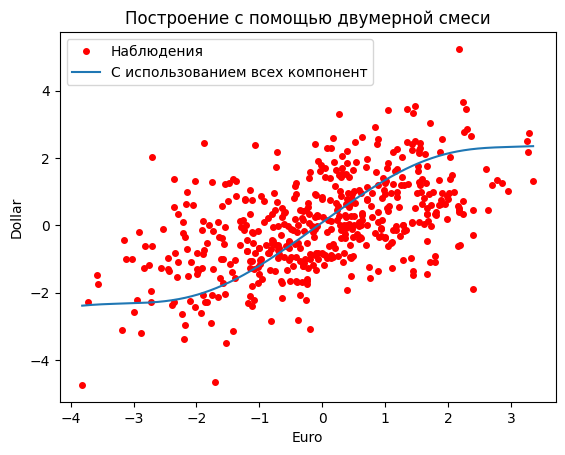

In [53]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_X, np_Y, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()

# Ядерная регрессия

## Семплирование

In [64]:
X_difs = X_train - X_train.reshape(1, X_train.shape[0])
X_difs.shape

(400, 400)

In [65]:
def K_h (x, h):
  return (1 / (2 * np.pi) ** 0.5) * (np.exp(-((x/h) ** 2) / 2)) / h

In [93]:
h = 0.4

In [94]:
class MyLogPDF(pints.LogPDF):
    
    def __init__(self):
        pass
            
    def n_parameters(self):
        # Tell the inference method how many parameters there are
        return 2

    def __call__(self, p):
        # Extract the parameter x from the parameter vector
        h = p[0]
        sigma = p[1]
        n = X_train.shape[0]

        if h <= 0 or sigma <= 0:
            return -np.inf
        
        # start = time.time()

        k_h = K_h(X_difs, h)
        np.fill_diagonal(k_h, 0)
        # print(time.time() - start)

        res = (k_h * y_train).sum(axis = 0) / (k_h.sum(axis = 0) + 1e-100)
        # print(time.time() - start)

        difs = (res - y_train.flatten()) ** 2
        # print(time.time() - start)
        
        const = - 0.5 * np.log(np.sqrt(2 * np.pi)) - n * np.log(sigma)
        sum_part = - difs.sum() / (2 * (sigma ** 2))

        # Calculate and return the log pdf
        return const + sum_part

logpdf = MyLogPDF()

print(logpdf([h, 1]))

-285.87051963137964


In [95]:
class MyLogPrior(pints.LogPrior):
    
    def __init__(self):
        pass
            
    def n_parameters(self):
        # Tell the inference method how many parameters there are
        return 2

    def __call__(self, p):
        # Extract the parameter x from the parameter vector
        h = p[0]
        sigma = p[1]

        if h <= 0 or sigma <= 0:
            return -np.inf

        # Calculate and return the log pdf
        return - np.log(sigma)

logprior = MyLogPrior()
print(logprior([h, 1]))

-0.0


In [96]:
logposterior = pints.LogPosterior(logpdf, logprior)
print(logposterior([h, 1]))

-285.87051963137964


In [103]:
n_chains = 4
xs = [[h, 1.2], [h, 1.2], [h, 1.2], [h, 1.2]]
mcmc = pints.MCMCController(logposterior, n_chains, xs,  method= pints.HaarioACMC)
# mcmc.set_parallel(parallel = True)

# for sampler in mcmc.samplers():
#     sampler.set_target_acceptance_rate()

mcmc.set_max_iterations(100000)
# mcmc.set_parallel(parallel=4)

chains = mcmc.run()

Using Haario adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval.  Accept.   Accept.   Accept.   Accept.   Time m:s
0     4       0         0         0         0          0:00.0
1     8       0         0         0.5       0          0:00.0
2     12      0.333     0.333     0.667     0          0:00.0
3     16      0.25      0.25      0.5       0.25       0:00.1
20    84      0.333     0.476     0.333     0.19       0:00.2
40    164     0.39      0.39      0.341     0.268      0:00.5
60    244     0.311     0.377     0.377     0.311      0:00.7
80    324     0.333     0.395     0.395     0.395      0:00.9
100   404     0.337     0.356     0.396     0.406      0:01.0
120   484     0.347     0.338843  0.397     0.355      0:01.2
140   564     0.348     0.348     0.383     0.333      0:01.4
160   644     0.36      0.354     0.36      0.342      0:01.6
180   724     0.354     0.331     0.359116  0.354      0:01.8
Initial phase completed.
200   804     0.348 

#### Распределение семплов

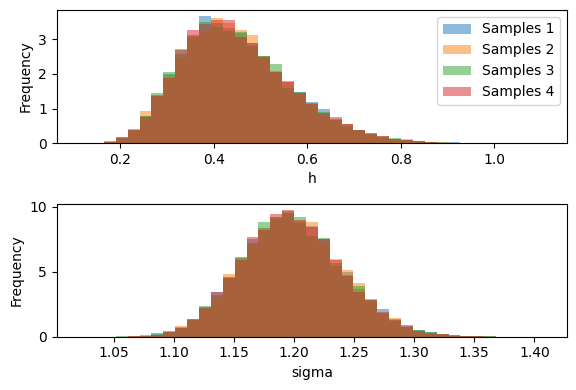

In [115]:
import matplotlib.pyplot as plt
import pints.plot

pints.plot.histogram(chains[:, 1000::, :], parameter_names=['h', 'sigma'])
plt.show()

#### Корреляция

In [105]:
print('Корелляция h: ', np.corrcoef(chains[0, 1000: -1, 0], chains[0, 1001:, 0])[0][1])
print('Корелляция sigma: ', np.corrcoef(chains[0, 1000: -1, 1], chains[0, 1001:, 1])[0][1])

Корелляция h:  0.7947862640520248
Корелляция sigma:  0.7946025749996544


In [106]:
print('Корелляция h: ', np.corrcoef(chains[0, 1000: -1:100, 0], chains[0, 1001::100, 0])[0][1])
print('Корелляция sigma: ', np.corrcoef(chains[0, 1000: -1:100, 1], chains[0, 1001::100, 1])[0][1])

Корелляция h:  0.8159113297743777
Корелляция sigma:  0.7642118811058388


In [112]:
new_chains = chains.mean(axis=0).reshape((1, 100000, 2))
new_chains.shape

(1, 100000, 2)

In [ ]:
result_10000 = pd.DataFrame(chains[0, :, :], columns= ['h', 'sigma'])
result_10000

,h,sigma
0,0.400000,1.200000
1,0.400000,1.200000
2,0.311379,1.144423
3,0.311379,1.144423
4,0.336548,1.150465
...,...,...
99995,0.607751,1.210193
99996,0.607751,1.210193
99997,0.607751,1.210193
99998,0.426211,1.219634


In [129]:
result_10000.to_excel('result_10000.xlsx', index=False)

## Анализ результатов

In [135]:
chains = pd.read_excel('result_10000.xlsx')
h_s = np.array(chains['h'])

In [138]:
chains = np.array(chains)

#### Внешний вид распределений

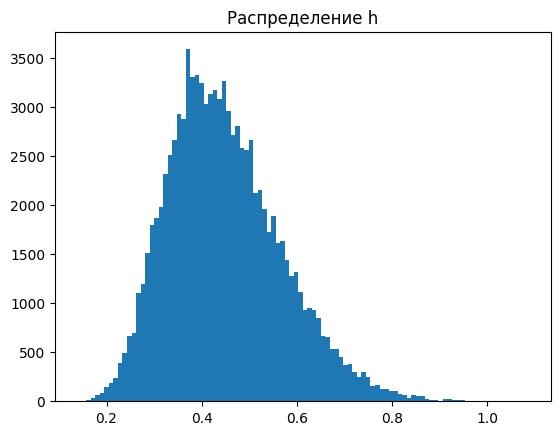

In [140]:
plt.hist(chains[1000::, 0], bins=100)
plt.title('Распределение h')
plt.show()

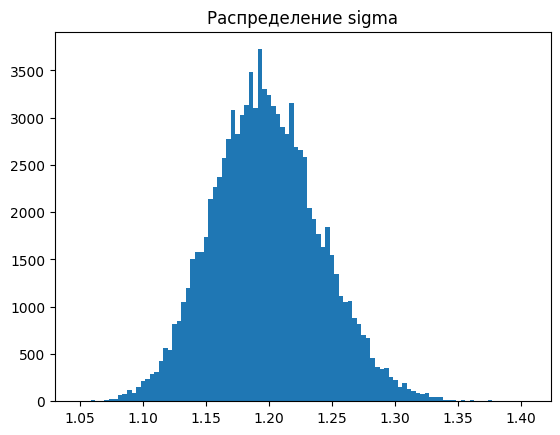

In [142]:
plt.hist(chains[1000::, 1], bins=100)
plt.title('Распределение sigma')
plt.show()

#### Рассчёт для среднего h

In [143]:
h_mean = h_s.mean()
h_mean

0.44878680964495854

In [144]:
var_Y = y_test.var(ddof= 1)
n_samples_test = y_test.shape[0]

# Считаем регрессию
k_h = K_h(X_test - X_test.reshape((n_samples_test)), h_mean)
res = (k_h * y_test).sum(axis = 0) / k_h.sum(axis = 0)
E_Y_X = res.reshape(-1, 1)

# Считаем остатки и их ковариацию с регрессией
residiuals = y_test - E_Y_X
covar = np.cov(E_Y_X.flatten(), residiuals.flatten())[0][1]

# Считаем дисперсии
var_E_X_Y = E_Y_X.var(ddof= 1)
var_resid = sum((residiuals ** 2) / (n_samples_test - 1))

# Смещённый R**2 и доля ковариции
R_2_shifted = var_E_X_Y / var_Y
cov_part = 2 * covar / var_Y

# Считаем несмещённый (по корреляции Пирсона)
y_true = y_test.flatten()  # реальные значения
y_pred = E_Y_X.flatten()   # предсказанные значения
r = np.corrcoef(y_true, y_pred)[0, 1]
r_squared = r ** 2

In [145]:
X_reshaped = X_test.reshape(1, -1)[0]
sorted_indices = np.argsort(X_reshaped)  # Получаем индексы для сортировки
X_sorted = X_reshaped[sorted_indices]
res_sorted = res[sorted_indices]

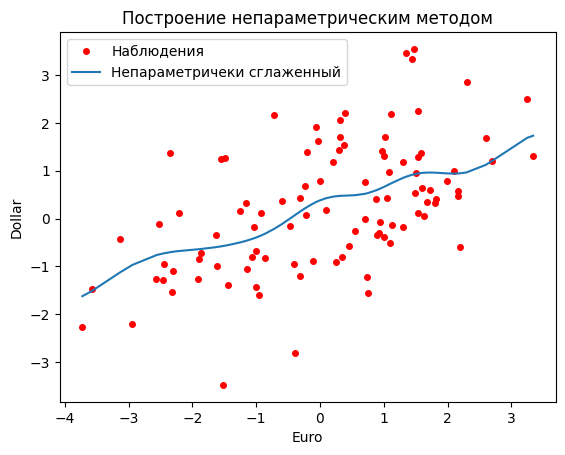

In [146]:
plt.title('Построение непараметрическим методом')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(X_test, y_test, 'ro', markersize=4)
plt.plot(X_sorted, res_sorted)
plt.legend(['Наблюдения', 'Непараметричеки сглаженный'])
plt.show()

Полученные характеристики

In [147]:
print('R^2 смещённый =', R_2_shifted)
print('R^2 с учётом ковариации =', r_squared)
print('Ковариация =', cov_part)

R^2 смещённый = 0.2734310275513428
R^2 с учётом ковариации = 0.3287829698064516
Ковариация = 0.05280273551140469


In [7]:
from tqdm import tqdm
import math

In [9]:
counter = 0
for i in tqdm(range(9 * 1000000)):
    counter += 2 * math.floor(math.sqrt(i + 0.5))
counter + 9 * 1000000

100%|██████████| 9000000/9000000 [00:02<00:00, 3947164.16it/s]


35999999000